In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
pd.options.mode.chained_assignment = None

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/reddit-vaccine-myths/reddit_vm.csv


In [3]:
df = pd.read_csv('/kaggle/input/reddit-vaccine-myths/reddit_vm.csv')

# Data Pre-processing

In order to get gain a better understanding of the content, the title and the body columns are combined into a single value

In [4]:
df['gp_sent'] = ''
for i, row in df.iterrows():
    if row['title'] == 'Comment':
        df['gp_sent'][i] =(row['body'])
    elif row['body']!='':
        df['gp_sent'][i] =(str(row['title']) + ' ' + str(row['body']))

In [5]:
#removing 'nan' values and rows which are empty
index = []
for i, row in df.iterrows():
    sent = re.sub('nan', '', row['gp_sent'])
    if not sent:
        index.append(i)     

In [6]:
index

[]

There are no empty rows in the dataset

In [7]:
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from spellchecker import SpellChecker
from datetime import datetime

lemmatizer = WordNetLemmatizer()

In [8]:
# Removing websites 

df['processed'] ='' 
website_pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
for i, row in df.iterrows():
    df['processed'][i] = ' '.join([re.sub(website_pattern,'',sent) for sent in re.split("[\(\[\)\]\\\n]", row['gp_sent'])])


Since reddit is an informal platform, usage of colloquial spelling/abbreviation is normal. Hence, it is important to rectify such words

In [9]:
#identify unique words

df['cleansed']=''
stop_words=stopwords.words('english')

unique_words = []

for i, row in df.iterrows():
    #check punctuations
    sent  = re.sub(r'[.]*|[,]*|:|[\n]*|nan|\?|"|[\*]*|[\t]*|[\r]*|&|#|!|<|>|%|[\^]*|', '', row['processed'])
    sent = sent.replace('-',' ')
    # remove numbers
    sent  = re.sub(r'\d', '', sent)
    for word in sent.lower().split(' '):
        if lemmatizer.lemmatize(word) not in unique_words and len(word)>2 and word not in stop_words:
            unique_words.append(word)

In [10]:
len(unique_words)

7738

In [11]:
# using spell checker to map mis-spelled words to a similar word of highest weightage

misspelled_map ={}
spell_checker = SpellChecker()

#adding frequently used new words that didn't exist previously
#with more research other new terms can also be added 
spell_checker.word_frequency.load_words(['covid', 'coronavirus', 'corona', 'astrazeneca','pfizer'])
misspelled_words = spell_checker.unknown(unique_words)
len(misspelled_words)

1276

Of *7672* unique words, *1264* words are misspelled

In [12]:
#correct misspelled words
# takes a long time to match and identify correct word. So to log progress we have a counter

count =1
for word in misspelled_words:
    misspelled_map[word] = spell_checker.correction(word)
    count = count+1
    if count%100==0:
        print(count)

100
200
300
400
500
600
700
800
900
1000
1100
1200


In [13]:
#replace misspelled words

for i, row in df.iterrows():
    df['cleansed'][i] = ' '.join([' '.join([misspelled_map[word] if word in misspelled_words else word for word in sent.split('-')]) for sent in row['processed'].lower().split(' ')])

In [14]:
#converting timestamp into date-time format
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.strptime(x[0:10], '%Y-%m-%d'))

# Sentiment Analysis

In [15]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [16]:
df['polarity_scores'] = df['cleansed'].map(lambda x: sid.polarity_scores(x))
df['comp_score'] = df['polarity_scores'].map(lambda x: x['compound'])
df['polarity'] = df['comp_score'].map(lambda x: 'pos' if x>0 else ('neu' if x==0 else 'neg'))

In [17]:
data = df.drop(['title','id','url', 'body', 'gp_sent','processed'], axis=1)


Lets visualize how the polarity has changed with score and comments and overtime

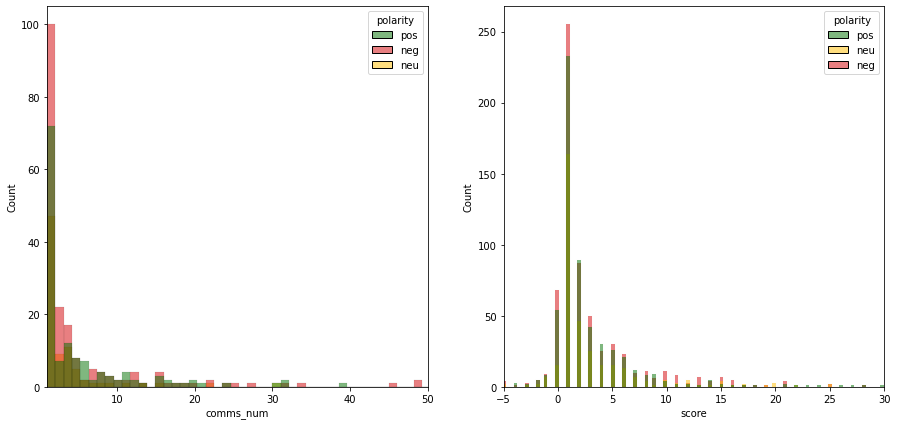

In [18]:
colors = [ "#007000", "#D20005", "#FFBF00"]
customPalette = sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(1, 2, figsize=(15,7))
sns.histplot(x='comms_num', hue='polarity', data=data[data['comms_num']>0],palette=customPalette, ax=ax[0])
ax[0].set_xlim(1,50)

colors = [ "#007000", "#FFBF00","#D20005"]
customPalette = sns.set_palette(sns.color_palette(colors))
#Change of score wrt polarity
sns.histplot(x='score', hue='polarity', data=data,palette=customPalette, ax=ax[1])
ax[1].set_xlim(-5,30)
plt.show()

Clearly, neg polarity is quite prominent garnering more comments and score.

In [19]:
# quanitfying the change in score and comments with polarity 

new = data[['score','comms_num','polarity']].groupby('polarity')
new.mean()

,score,comms_num
polarity,,
neg,4.870170,2.888717
neu,3.126801,0.832853
pos,2.732517,1.330420


We see than more than tweets with positive and neutral polarity, those with *negative polarity has been more active* and based on its score, *producing a higher impact.*

In [20]:
#fig, ax = plt.subplots(figsize=(10,10))
#sns.lineplot(x="timestamp",hue="polarity",data=data)
#plt.show()

# NMF Topic Model - Negative Tweets

Starting with processing negative tweets, to understand better the reason for the apprehensions towards vaccines

In [21]:
import nltk
from nltk.tokenize import WordPunctTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF;
 
#Using WordPunctTokenizer since it accomodates separating punctuations from words
tokenizer = WordPunctTokenizer()


In [22]:
def process_tweets(df):
    processed =[]
    for i, row in df.iterrows():
        #remove numbers
        tweet  = re.sub(r'\d', '', row['cleansed'])
        #tokenize the text
        tweet = tokenizer.tokenize(tweet)
        #remove punctuations and empty string
        tweet = [word for word in tweet if len(word)>2 and ' ' not in word and 'nan' not in word]
        #remove stop words
        tweet = [word for word in tweet if word not in stop_words]
        # Lemmatize words
        processed.append([lemmatizer.lemmatize(word) for word in tweet])
    return processed

In [23]:
def vectorize(tweet_list):
    tfidf_vectorizer = TfidfVectorizer(min_df=3, max_df=0.85, max_features=5000,ngram_range=(1, 2), preprocessor=' '.join)
    tfidf = tfidf_vectorizer.fit_transform(tweet_list)
    return tfidf, tfidf_vectorizer

In [24]:
def get_nmf_topics(model, n_top_words, tfidf_vectorizer):
    
    feat_names = tfidf_vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(n_top_words):
        words_ids = model.components_[i].argsort()[:-15 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

Modeling with fixed k=5

In [25]:
#processing negative tweets
neg_tweets_df = data[data["polarity"] == "neg"]
neg_list = process_tweets(neg_tweets_df)
print(neg_list[0:2])

[['fuck', 'anti', 'waxing', 'retard'], ['anti', 'baxters', 'sense']]


In [26]:
#Running a sample model wit k as 5, before choosing the optimal components
model_neg = NMF(n_components=5, init='nndsvd');
tfidf_neg, tfidf_vectorizer_neg = vectorize(neg_list)
model_neg.fit_transform(tfidf_neg)
nmf_df_neg = get_nmf_topics(model_neg, 5,tfidf_vectorizer_neg )
nmf_df_neg[0:10]

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05
0,vaccinated,anti,wrong,autism,vaccine
1,people,anti van,bad,cause,cell
2,would,van,faith,vaccine cause,anything
3,one,baxters,bad faith,cause autism,bad
4,child,anti baxters,comment,damage,know
5,get,anti vaccine,saying,brain,mercury
6,measles,anti baxter,want,vaccine,anti vaccine
7,study,baxter,source,brain damage,virus
8,immunity,chili,think,rate,polio
9,vaccination,maxx,think wrong,saying,mercury vaccine


Use Coherence score to identify the optimal number of components

In [27]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from operator import itemgetter

In [28]:
def coherence_model(tweets):
    topic_nums = list(np.arange(3,63,3))
    coherence_scores =[]
    
    #get corpus
    dictionary = Dictionary(tweets)
    dictionary.filter_extremes(no_below=3,no_above=0.85,keep_n=5000)
    corpus = [dictionary.doc2bow(word) for word in tweets]
    
    #compute coherence model
    for num in topic_nums:
        nmf = Nmf(corpus=corpus,num_topics=num,id2word=dictionary,chunksize=2000,passes=5,kappa=.1,
                  minimum_probability=0.01,w_max_iter=300,w_stop_condition=0.0001,h_max_iter=100,
                  h_stop_condition=0.001,eval_every=10,normalize=True,random_state=42)
        cm = CoherenceModel(model=nmf, texts=tweets, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(round(cm.get_coherence(), 5))
        if(num%9==0):
            print(num)
    return list(zip(topic_nums, coherence_scores))

In [29]:
neg_scores = coherence_model(neg_list)

9
18
27
36
45
54


In [30]:
neg_df  = pd.DataFrame(neg_scores)
idmax = neg_df.iloc[:,1].idxmax(axis=1)
best_cv_neg, cv_neg = int(neg_df.loc[idmax][0]), neg_df.loc[idmax][1]

Best k:18 and cv_score:0.44336


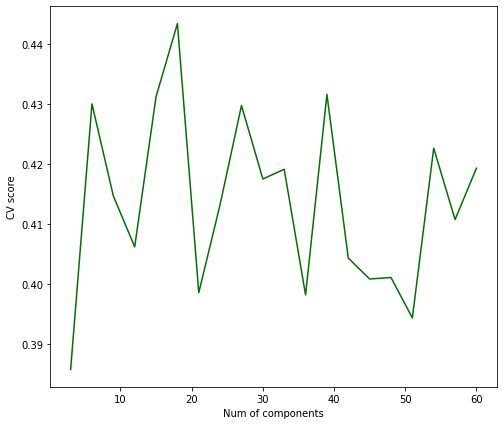

In [31]:
print('Best k:{} and cv_score:{}'.format(best_cv_neg, cv_neg))

fig, ax = plt.subplots(figsize=(8,7))
sns.lineplot(data=neg_df, x=0, y=1)
plt.xlabel('Num of components')
plt.ylabel('CV score')
plt.show()

In [32]:
model_opt_neg = NMF(n_components=best_cv_neg, init='nndsvd');
tfidf_opt_neg, tfidf_vectorizer_opt_neg = vectorize(neg_list)
model_opt_neg.fit_transform(tfidf_opt_neg)
nmf_df_opt_neg = get_nmf_topics(model_opt_neg, best_cv_neg,tfidf_vectorizer_opt_neg )
nmf_df_opt_neg

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18
0,flu,anti,wrong,autism,vaccine,vaccinated,bad,would,study,brain,measles,know,people,like,misinformation,dumb,cell,fuck
1,shot,anti van,comment,cause,anything,kid,bad faith,idiot,child,damage,death,mercury,think,company,spread,one,virus,shit
2,year,van,faith,cause autism,anti vaccine,immunity,faith,say,wakefield,brain damage,case,mercury vaccine,want,general,kill,yes,cancer,read
3,vaccination,anti baxters,source,vaccine cause,polio,risk,vaccine bad,want,conclusion,going,rate,post,stupid,god,spread misinformation,arent,immune,retard
4,flu shot,baxters,get,rate,asking,pertussis,man,lying,read,blood,error,thimerosal,really,day,mind,person,immune system,actual
5,flu vaccine,anti vaccine,bad faith,vaccine,exposed,vaccinated kid,see,antivaxxers,paper,dip,also,know vaccine,damn,use,time,especially,system,one
6,get,baxter,think wrong,saying,still,child,accusation,thank,say,sodium,died,right,actually,keep,killed,aluminium,make,inject
7,one,anti baxter,saying,mar,take,vaccinated child,argument,odd,even,cause,fatality,let,vaccination,product,sheep,take,live,say
8,every,chili,title,could,first,disease,talking,allergy,point,cause damage,fatality rate,result,going,thing,idiot,see,body,reddit
9,flu vaccination,maxx,want,argument,war,person,sure,something,link,problem,adult,chemistry,saying,crap,kid,difference,dead,revoked




Each topic gives an understanding of the reasons behind the negativeness towards vaccines.

For example,
Topic 1 can be categorized as 'mercury(thimerosal), sodium content'
Topic 3 : no trust
Topic 4 : Cause Autism
Topic 10 : death fatalities 
.
.
etc

Analysing the content of each topic by manually perusal of human beings can be extremely challenging. Methods such as identifying the most important topics based on *residuals* can be adopted to overcome the disadvantage of high time consumption

This model can be used to gain an idea about the negatives surrounding vaccinations among the general public.

The same can be replicated with postive tweetsto help understand and amplify the positive opinions on vaccinations